## ARISE-1.5 in the cloud

Notebook shows how to access ARISE-1.5 CESM2-WACCM data from the AWS web store. 
https://aws.amazon.com/marketplace/pp/prodview-7r3ocbnp5exq2#overview
https://registry.opendata.aws/ncar-cesm2-arise/

Unfortunately, I had problems using the catalogs (https://github.com/NCAR/CESM2-ARISE/tree/main) with intake-esm. So we have had to hard code a file path here, which is not ideal. 

In [1]:
## packages for cloud data intake: 
import s3fs
import intake #intake-esm
import fsspec


## packages for analysis
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt


In [2]:
## test reading in a file to a dataset:
loc = 'ncar-cesm2-arise/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.001/atm/proc/tseries/month_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.001.cam.h0.TREFHT.203501-206912.nc'

s3_path = "s3://" + loc

# Open the dataset directly from the S3 URL using xarray
with fsspec.open(s3_path, mode='rb', anon=True) as file:
    ds = xr.open_dataset(file, engine="h5netcdf")
ds['TREFHT']

<xarray.DataArray 'TREFHT' (time: 420, lat: 192, lon: 288)> Size: 93MB
[23224320 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 3kB 2035-02-01 00:00:00 ... 2070-01-01 00:00:00
Attributes:
    units:         K
    long_name:     Reference height temperature
    cell_methods:  time: mean

In [3]:
def get_trefht_data(scenario='ARISE'):
    da_list = []
    members = ['001', '002', '003', '004', '005']

    for member in members:

        locs = {'ARISE':'ncar-cesm2-arise/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.{m}/atm/proc/tseries/month_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.{m}.cam.h0.TREFHT.203501-206912.nc'.format(m=member),
                'SSP245_1':'ncar-cesm2-arise/CESM2-WACCM-SSP245/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.{m}/atm/proc/tseries/month_1/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.{m}.cam.h0.TREFHT.201501-206412.nc'.format(m=member),
                'SSP245_2':'ncar-cesm2-arise/CESM2-WACCM-SSP245/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.{m}/atm/proc/tseries/month_1/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.{m}.cam.h0.TREFHT.206501-210012.nc'.format(m=member)}
        loc = locs[scenario]
        s3_path = "s3://" + loc
        # Open the dataset directly from the S3 URL using xarray
        with fsspec.open(s3_path, mode='rb', anon=True) as file:
            da = xr.open_dataset(file, engine="h5netcdf")['TREFHT']
            da_list.append(da.load()) 
            # note that this takes a decent chunk of memory as we dont do anything clever with dask here            
    ds = xr.concat(da_list, dim='member_id').assign_coords({'member_id':members})       
    
    return ds

In [4]:
## get data for the geoengineering and the background (ssp245) scenario. 
## ssp245 is split into two files, as this run is longer

ds_arise = get_trefht_data('ARISE')
ds_ssp245_early = get_trefht_data('SSP245_1')
ds_ssp245_late = get_trefht_data('SSP245_2')

ds_ssp245 = xr.concat([ds_ssp245_early, ds_ssp245_late], dim='time')


## As an example, lets show timeseries of 3 metrics 
- the global mean temp.
- the interhemispheric temp. gradient
- the equator to pole temp. gradient

note that these are the three temp. targets used by the controller (T0, T1 and T2), but we will deliberately not use the precise metrics as targetted for T1 and T2 here, instead using simple related proxies. 

In [5]:
### first resample data to yearly resolution:
ds_arise = ds_arise.groupby('time.year').mean('time')
ds_ssp245 = ds_ssp245.groupby('time.year').mean('time')

# drop final year because it is incomplete:
ds_arise = ds_arise.where(ds_arise.year<2065, drop=True)
ds_ssp245 = ds_ssp245.where(ds_ssp245.year<2100, drop=True)

In [6]:
## next get global means:
weights = np.cos(np.deg2rad(ds_arise['lat']))
ds_arise_global_mean =  ds_arise.weighted(weights).mean(dim='lat').mean('lon')
weights = np.cos(np.deg2rad(ds_ssp245['lat']))
ds_ssp245_global_mean =  ds_ssp245.weighted(weights).mean(dim='lat').mean('lon')

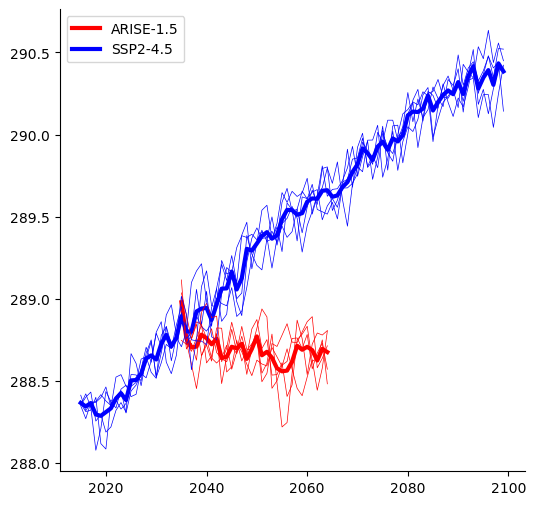

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(ds_arise_global_mean.year.values, ds_arise_global_mean.mean('member_id').values,
            color = 'red', label='ARISE-1.5', lw=3)
ax.plot(ds_ssp245_global_mean.year.values, ds_ssp245_global_mean.mean('member_id').values,
                color='blue', label='SSP2-4.5', lw=3)

for member in ['001', '002', '003', '004', '005']:
    ax.plot(ds_arise_global_mean.year.values, ds_arise_global_mean.sel(member_id=member).values,
            color = 'red', lw=0.5)
    ax.plot(ds_ssp245_global_mean.year.values, ds_ssp245_global_mean.sel(member_id=member).values,
                color='blue', lw=0.5)
ax.legend()
ax.spines[['right', 'top']].set_visible(False)


plt.savefig('ARISE_cloud_example.jpg')